In [160]:
import gc
import dill
import os
import random
import time
import pickle
import re
import json
import inspect

import torch
import torchaudio
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import functional as F
from torchaudio.transforms import MelSpectrogram, Resample
from torchaudio.functional import preemphasis, deemphasis

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

from librosa.filters import mel as librosa_mel_fn

from dataset.dataset import AudioDataset, TTSDataset
from utils import MelSpec

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [116]:
SAMPLE_RATE = 22050
SEQ_LENGTH = 8192
N_FFT = 1024
WIN_LEN = 1024
HOP_LEN = 256
PAD = (N_FFT - HOP_LEN) // 2
MEC_SPEC_CONF_TACOTRON = dict(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_mels=80,
    f_min=40,
    f_max=8000,
    power=1,
    center=False,
    pad=PAD,
    mel_scale="slaney",
    norm="slaney",
)

In [117]:
SAMPLE_RATE = 24000
SEQ_LENGTH = 8192
N_FFT = 2048
WIN_LEN = int(SAMPLE_RATE * 0.05)
HOP_LEN = int(SAMPLE_RATE * 0.0125)
PAD = 640
MEC_SPEC_CONF_TACOTRON_VW = dict(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_mels=80,
    f_min=40,
    f_max=8000,
    power=1.2,
    pad=PAD,
    # log_fn=lambda x: torch.log10(x),
    log_fn=lambda x: 20 * torch.log10(x),
    # norm_fn=lambda x: torch.clamp((x + 100) / 100, 0),
)

In [118]:
MEC_SPEC_CONF_TACOTRON_VW

{'sample_rate': 24000,
 'n_fft': 2048,
 'win_length': 1200,
 'hop_length': 300,
 'n_mels': 80,
 'f_min': 40,
 'f_max': 8000,
 'power': 1.2,
 'pad': 640,
 'log_fn': <function __main__.<lambda>(x)>}

In [120]:
MODEL_TAG = "melgan_8192_24k_100_vw_base_nonorm"

In [121]:
try:
    os.mkdir(f"models/{MODEL_TAG}")
    os.mkdir(f"models/{MODEL_TAG}/checkpoints")
    os.mkdir(f"models/{MODEL_TAG}/samples")
    print("ok")
except FileExistsError:
    print("already exists")

ok


In [122]:
MEL_SPEC_CONF = MEC_SPEC_CONF_TACOTRON_VW.copy()

In [128]:
def lambda2str(fn):
    if fn is None:
        return "None"
    return inspect.getsourcelines(fn)[0][0].strip()

In [129]:
print(lambda2str(MEL_SPEC_CONF.get("log_fn", torch.log)))
print(lambda2str(MEL_SPEC_CONF.get("norm_fn", None)))
MEL_SPEC_CONF

log_fn=lambda x: 20 * torch.log10(x),
None


{'sample_rate': 24000,
 'n_fft': 2048,
 'win_length': 1200,
 'hop_length': 300,
 'n_mels': 80,
 'f_min': 40,
 'f_max': 8000,
 'power': 1.2,
 'pad': 640,
 'log_fn': <function __main__.<lambda>(x)>}

In [131]:
try:
    MEL_SPEC_CONF = dill.load(open(f"models/{MODEL_TAG}/mel_spec_conf", "rb"))
except:
    dill.dump(MEL_SPEC_CONF, open(f"models/{MODEL_TAG}/mel_spec_conf", "wb"))

In [132]:
dill.dump(MEL_SPEC_CONF, open(f"models/{MODEL_TAG}/mel_spec_conf", "wb"))

In [133]:
dataset = AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", SAMPLE_RATE, segment_length=SEQ_LENGTH)
dataset_val = AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", SAMPLE_RATE)
mel_featurizer = MelSpec(MEL_SPEC_CONF)

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

try:
    random_indexes = pickle.load(open(f"models/{MODEL_TAG}/indexes", "rb"))
except:
    random_indexes = torch.randperm(len(dataset)).tolist()
dataset_train = Subset(dataset, random_indexes[:train_size])
dataset_test = Subset(dataset_val, random_indexes[train_size:])

In [134]:
pickle.dump(random_indexes, open(f"models/{MODEL_TAG}/indexes", "wb"))

In [136]:
len(dataset_train), len(dataset_test)

(106200, 11800)

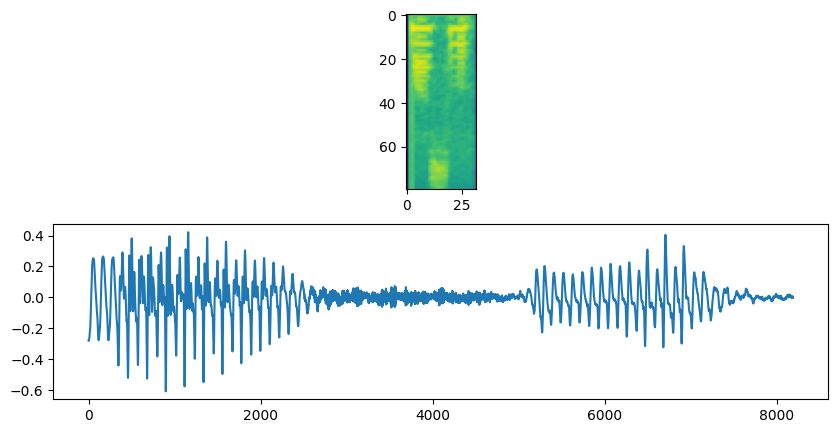

In [137]:
audio = dataset_train[0]
mel = mel_featurizer(audio)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mel)
axes[1].plot(audio[0])

display.Audio(audio, rate=dataset.sample_rate)

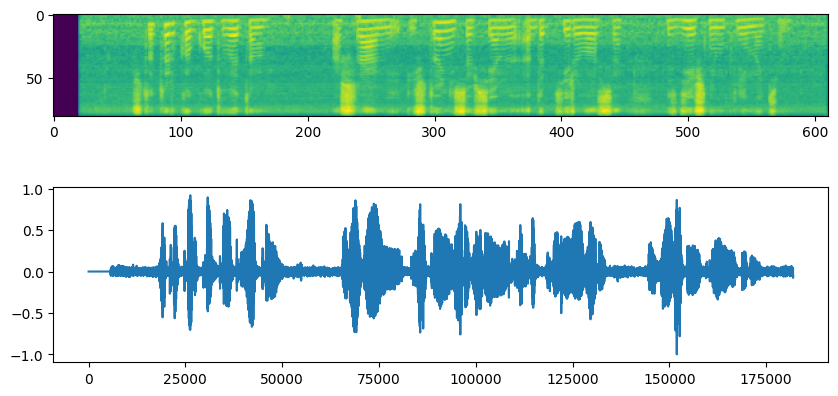

In [138]:
audio = dataset_test[0]
mel = mel_featurizer(audio)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mel)
axes[1].plot(audio[0])

display.Audio(audio, rate=dataset.sample_rate)

In [140]:
def collate_fn(items):
    audio_len = [audio.size(1) for audio, _ in items]
    texts = [code_text(text) for _, text in items]
    text_len = [text.size(1) for text in texts]
    
    audio_batch = torch.zeros((len(items), max(audio_len)))
    text_batch = torch.zeros((len(texts), max(text_len)))
    for i, (audio, _) in enumerate(items):
        audio_batch[i, :audio_len[i]] = audio
        text_batch[i, :text_len[i]] = texts[i]
    return audio_batch, text_batch.long()

In [141]:
dataloader_train = DataLoader(dataset_train, 32, shuffle=True, drop_last=True, num_workers=24)#, collate_fn=collate_fn)
dataloader_test = DataLoader(dataset_test, 1, pin_memory=True)

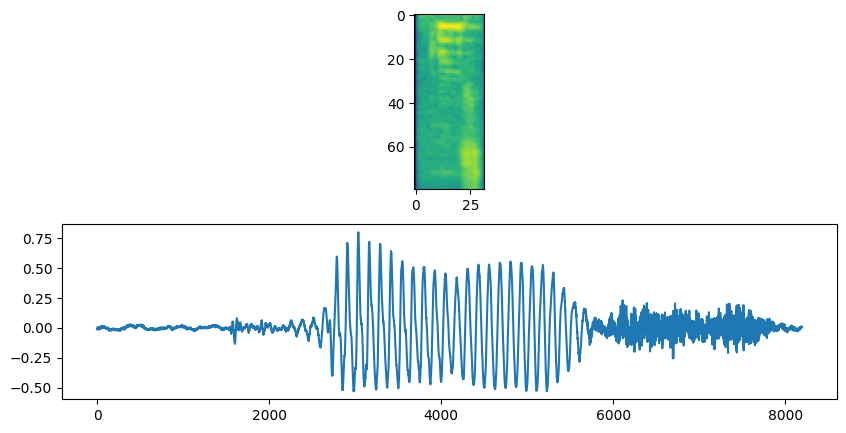

In [142]:
audios = next(iter(dataloader_train))
mels = mel_featurizer(audios)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mels[0])
axes[1].plot(audios[0][0])

display.Audio(audios[0], rate=dataset.sample_rate)

In [89]:
from melgan import generator, discriminator
import importlib
importlib.reload(generator)
importlib.reload(discriminator)

from melgan.generator import Generator
from melgan.discriminator import Discriminator

In [90]:
D_LAYERS = 4
LAMBDA = 10

In [143]:
gen = generator.Generator(80, 32, 3).to(DEVICE)
disc = discriminator.Discriminator(3, 16, D_LAYERS, 4).to(DEVICE)

In [144]:
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [147]:
mel_featurizer = MelSpec(MEL_SPEC_CONF).to(DEVICE)
print(lambda2str(mel_featurizer.conf.get("log_fn", torch.log)))
print(lambda2str(mel_featurizer.conf.get("norm_fn", None)))
mel_featurizer.conf

log_fn=lambda x: 20 * torch.log10(x),
None


{'sample_rate': 24000,
 'n_fft': 2048,
 'win_length': 1200,
 'hop_length': 300,
 'n_mels': 80,
 'f_min': 40,
 'f_max': 8000,
 'power': 1.2,
 'pad': 640,
 'log_fn': <function __main__.<lambda>(x)>}

In [149]:
wav = next(iter(dataloader_train))
wav = wav.to(DEVICE)
mels = mel_featurizer(wav)

fake_wav = gen(mels)
disc_result = disc(fake_wav)
fake_mels = mel_featurizer(fake_wav)
print(wav.size(), fake_wav.size())
print(mels.size(), fake_mels.size())
print(disc_result[0][-1].size())

assert wav.size() == fake_wav.size()
assert mels.size() == fake_mels.size()
del wav
del fake_wav
del mels
del fake_mels
del disc_result
clear_mem()

torch.Size([32, 1, 8192]) torch.Size([32, 1, 8192])
torch.Size([32, 80, 32]) torch.Size([32, 80, 32])
torch.Size([32, 1, 32])


In [150]:
def disc_loss(D_fake, D_real):
    loss = 0
    for scale in D_fake:
        loss += F.relu(1 + scale[-1]).mean()
    for scale in D_real:
        loss += F.relu(1 - scale[-1]).mean()
    return loss

def gen_loss(D_fake):
    loss = 0
    for scale in D_fake:
        loss += -scale[-1].mean()
    return loss

def feature_loss(D_fake, D_real):
    loss_feat = 0
    feat_weights = 4.0 / (D_LAYERS + 1)
    D_weights = 1.0 / len(D_fake)
    wt = D_weights * feat_weights
    for i in range(len(D_fake)):
        for j in range(len(D_fake[i]) - 1):
            loss_feat += wt * F.l1_loss(D_fake[i][j], D_real[i][j].detach())
    return loss_feat

In [153]:
def train(epoch, gen, disc, opt_gen, opt_disc, dataloader):
    progress = tqdm(dataloader, desc=f"Train #{epoch}\n")
    
    losses = {
        "disc": [],
        "gen": [],
        "feature": [],
        "mel": [],
    }
    
    gen.train()
    disc.train()
    for wav in progress:
        wav = wav.to(DEVICE)
        # wav = preemphasis(wav)

        mel = mel_featurizer(wav).detach()
        
        wav_fake = gen(mel)
        
        with torch.no_grad():
            mel_fake = mel_featurizer(wav_fake.detach())
            loss_mel = F.l1_loss(mel, mel_fake)
        
        D_fake = disc(wav_fake.detach())
        D_real = disc(wav)
        
        loss_D = disc_loss(D_fake, D_real)
        
        disc.zero_grad()
        loss_D.backward()
        opt_disc.step()
        
        D_fake = disc(wav_fake)
        loss_G = gen_loss(D_fake)
        loss_feat = feature_loss(D_fake, D_real)
        
        gen.zero_grad()
        (loss_G + LAMBDA * loss_feat).backward()
        opt_gen.step()
        
        losses["disc"].append(loss_D.item())
        losses["gen"].append(loss_G.item())
        losses["feature"].append(loss_feat.item())
        losses["mel"].append(loss_mel.item())
        
        progress.set_description((
            f"Epoch #{epoch} | "
            f"D: {loss_D.item():0.3} | "
            f"G: {loss_G.item():0.3} | "
            f"F: {loss_feat.item():0.3} | "
            f"M: {loss_mel.item():0.3}"
        ))
        
    return losses

In [154]:
def test(epoch, gen, disc, dataloader, n_samples=10):
    progress = tqdm(range(10), desc=f"Test #{epoch}\n")
    dataloader = iter(dataloader)

    gen.eval()
    disc.eval()
    with torch.no_grad():
        for i in progress:
            wav = next(dataloader)
            wav = wav.to(DEVICE)
            # wav = preemphasis(wav)
            
            mel = mel_featurizer(wav).detach()
            wav_fake = gen(mel)

            # timestamp = str(int(time.time() * 1000))
            # torchaudio.save(f"models/{MODEL_TAG}/samples/{epoch}_{i}.wav", wav_fake.squeeze(0).cpu(), SAMPLE_RATE)
            # wav_fake = deemphasis(wav_fake)
            torchaudio.save(f"models/{MODEL_TAG}/samples/{epoch}_{i}.wav", wav_fake.cpu(), SAMPLE_RATE)

In [155]:
torch.backends.cudnn.benchmark = True
EPOCHS = 100
EPOCH_OFFSET = 0
checkpoint = (EPOCH_OFFSET - 1) % 10
train_losses = []

if EPOCH_OFFSET:
    train_losses = json.load(open(f"models/{MODEL_TAG}/losses.json", "r"))
    gen.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/gen_{checkpoint}.pt", map_location="cuda"))
    opt_gen.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/opt_gen_{checkpoint}.pt", map_location="cuda"))
    disc.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/disc_{checkpoint}.pt", map_location="cuda"))
    opt_disc.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/opt_disc_{checkpoint}.pt", map_location="cuda"))

In [156]:
len(train_losses)

0

In [157]:
for epoch in range(EPOCH_OFFSET, EPOCHS + EPOCH_OFFSET):
    train_losses.append(train(epoch, gen, disc, opt_gen, opt_disc, dataloader_train))
    test(epoch, gen, disc, dataloader_test)
    
    checkpoint = epoch % 10

    torch.save(gen.state_dict(), f"models/{MODEL_TAG}/checkpoints/gen_{checkpoint}.pt")
    torch.save(opt_gen.state_dict(), f"models/{MODEL_TAG}/checkpoints/opt_gen_{checkpoint}.pt")
    torch.save(disc.state_dict(), f"models/{MODEL_TAG}/checkpoints/disc_{checkpoint}.pt")
    torch.save(opt_disc.state_dict(), f"models/{MODEL_TAG}/checkpoints/opt_disc_{checkpoint}.pt")
    json.dump(train_losses, open(f"models/{MODEL_TAG}/losses.json", "w"))

Train #0
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #0
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #1
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #1
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #2
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #2
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #3
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #3
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #4
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #4
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #5
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #5
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #6
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #6
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #7
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #7
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #8
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #8
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #9
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #9
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #10
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #10
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #11
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #11
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #12
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #12
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #13
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #13
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #14
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #14
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #15
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #15
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #16
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #16
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #17
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #17
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #18
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #18
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #19
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #19
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #20
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #20
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #21
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #21
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #22
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #22
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #23
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #23
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #24
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #24
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #25
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #25
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #26
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #26
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #27
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #27
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #28
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #28
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #29
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #29
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #30
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #30
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #31
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #31
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #32
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #32
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #33
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #33
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #34
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #34
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #35
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #35
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #36
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #36
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #37
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #37
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #38
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #38
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #39
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #39
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #40
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #40
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #41
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #41
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #42
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #42
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #43
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #43
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #44
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #44
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #45
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #45
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #46
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #46
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #47
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #47
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #48
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #48
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #49
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #49
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #50
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #50
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #51
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #51
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #52
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #52
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #53
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #53
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #54
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #54
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #55
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #55
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #56
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #56
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #57
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #57
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #58
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #58
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #59
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #59
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #60
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #60
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #61
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #61
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #62
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #62
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #63
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #63
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #64
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #64
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #65
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #65
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #66
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #66
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #67
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #67
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #68
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #68
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #69
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #69
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #70
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #70
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #71
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #71
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #72
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #72
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #73
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #73
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #74
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #74
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #75
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #75
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #76
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #76
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #77
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #77
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #78
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #78
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #79
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #79
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #80
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #80
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #81
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #81
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #82
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #82
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #83
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #83
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #84
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #84
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #85
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #85
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #86
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #86
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #87
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #87
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #88
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #88
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #89
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #89
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #90
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #90
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #91
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #91
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #92
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #92
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #93
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #93
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #94
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #94
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #95
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #95
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #96
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #96
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #97
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #97
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #98
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #98
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #99
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #99
:   0%|          | 0/10 [00:00<?, ?it/s]

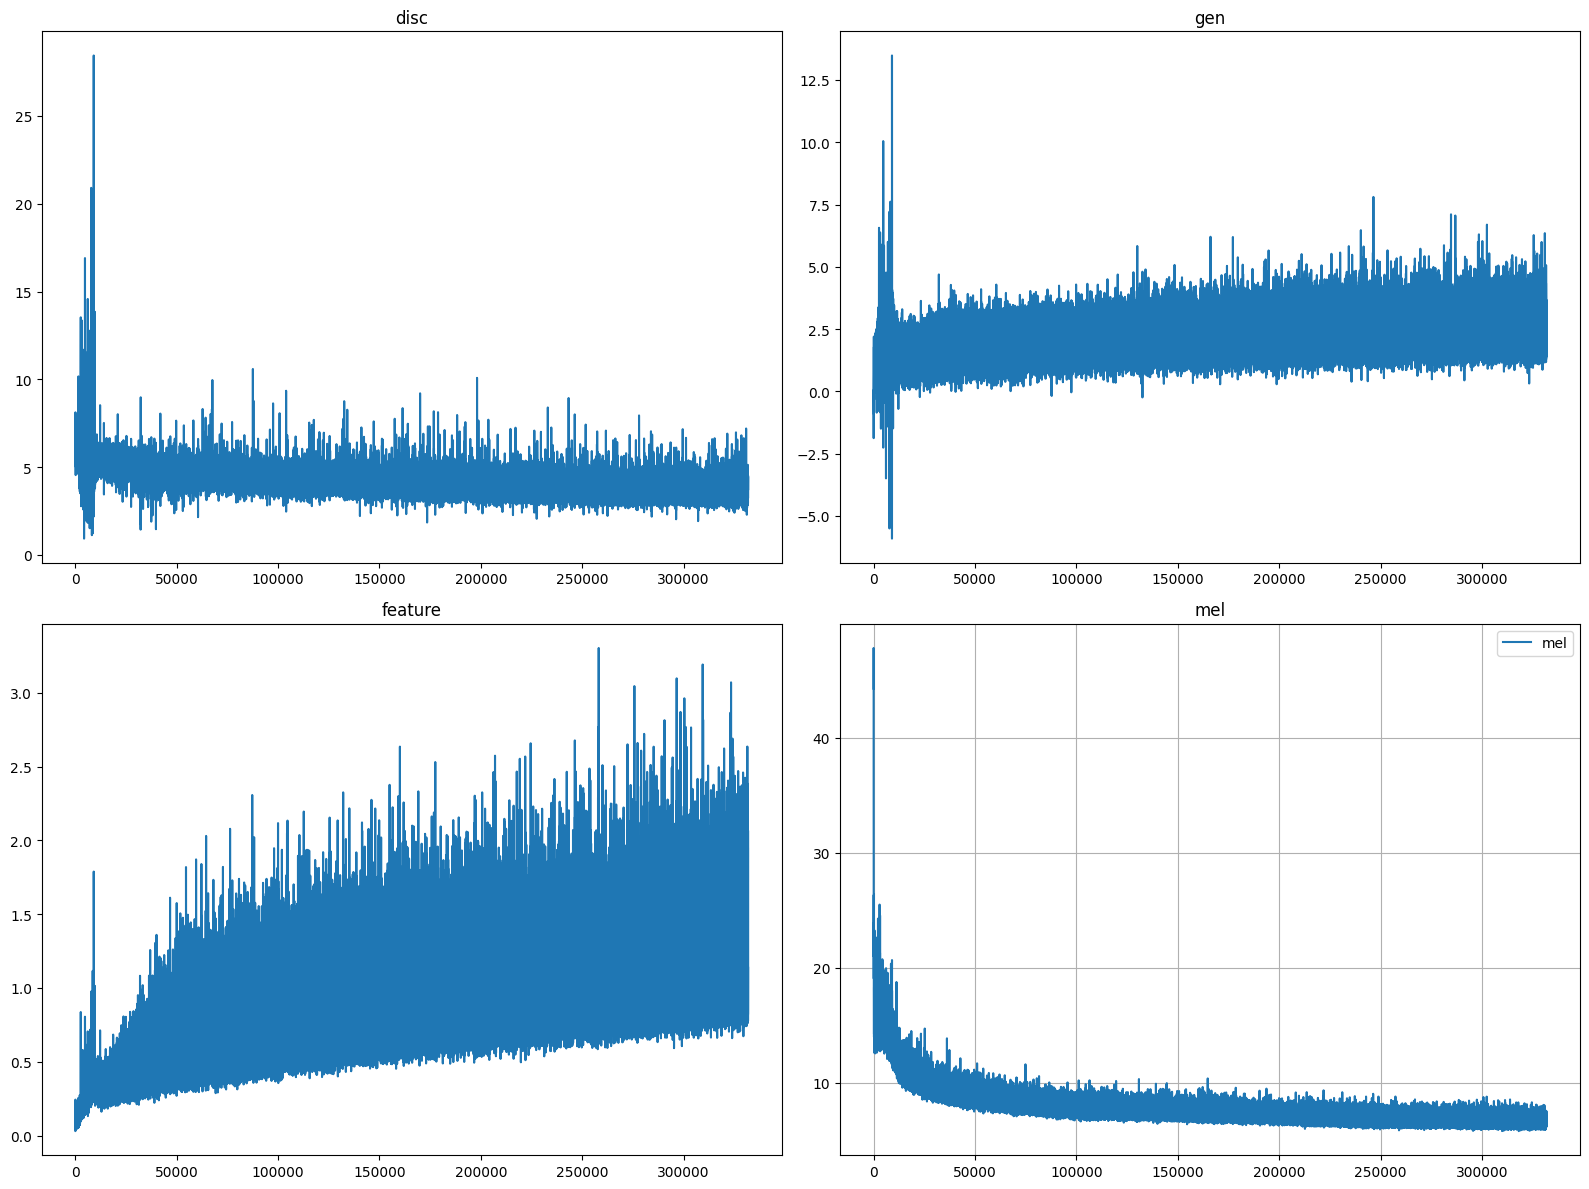

In [159]:
plt.figure(figsize=(16, 12))

for i, key in enumerate(["disc", "gen", "feature", "mel"]):
    plt.subplot(2, 2, i + 1)
    plt.plot(sum([losses[key] for losses in train_losses[:]], start=[]), label=key)
    plt.title(key)
    
plt.grid()
plt.tight_layout()
plt.legend()